# Task 1 Implement a system that can predict the PM2.5 level
Using previous data of Five Chinese Cities Data Set

## Get Data

I already did Data Preprocessing in another Jupyter Notebook File. 

Please find 'Data Preparation' folder which consists of notebook files to see what steps I have done

In [1]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
DATASET_DIR_PATH = 'PREP_DATASET'
DATASET_FILE_NAME = 'PREP_PM_DATASET.csv'
DATASET_FILE_PATH = os.path.join(DATASET_DIR_PATH, DATASET_FILE_NAME)

In [3]:
def load_data_from_csv(data_path):
    return pd.read_csv(data_path)

In [4]:
data = load_data_from_csv(DATASET_FILE_PATH)

In [5]:
data.head()

,Unnamed: 0,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM,City
0,0,2010,1,1,23,4.0,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0,Beijing
1,1,2010,1,2,0,4.0,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0,Beijing
2,2,2010,1,2,1,4.0,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0,Beijing
3,3,2010,1,2,2,4.0,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0,Beijing
4,4,2010,1,2,3,4.0,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0,Beijing


We will remove Unnamed column. It is appearing on itself...strange

In [6]:
data = data.drop(['Unnamed: 0'], axis=1)

In [7]:
data.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM,City
0,2010,1,1,23,4.0,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0,Beijing
1,2010,1,2,0,4.0,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0,Beijing
2,2010,1,2,1,4.0,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0,Beijing
3,2010,1,2,2,4.0,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0,Beijing
4,2010,1,2,3,4.0,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0,Beijing


There you go! 5 top rows in dataset

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436792 entries, 0 to 436791
Data columns (total 15 columns):
year             436792 non-null int64
month            436792 non-null int64
day              436792 non-null int64
hour             436792 non-null int64
season           436792 non-null float64
DEWP             436792 non-null float64
HUMI             436792 non-null float64
PRES             436792 non-null float64
TEMP             436792 non-null float64
cbwd             436792 non-null object
Iws              436792 non-null float64
precipitation    436792 non-null float64
Iprec            436792 non-null float64
PM               436792 non-null float64
City             436792 non-null object
dtypes: float64(9), int64(4), object(2)
memory usage: 50.0+ MB


Cleaned and non-null and no outliers. Everything was removed in Data Preparation Part

And we 436792 instances which is nice

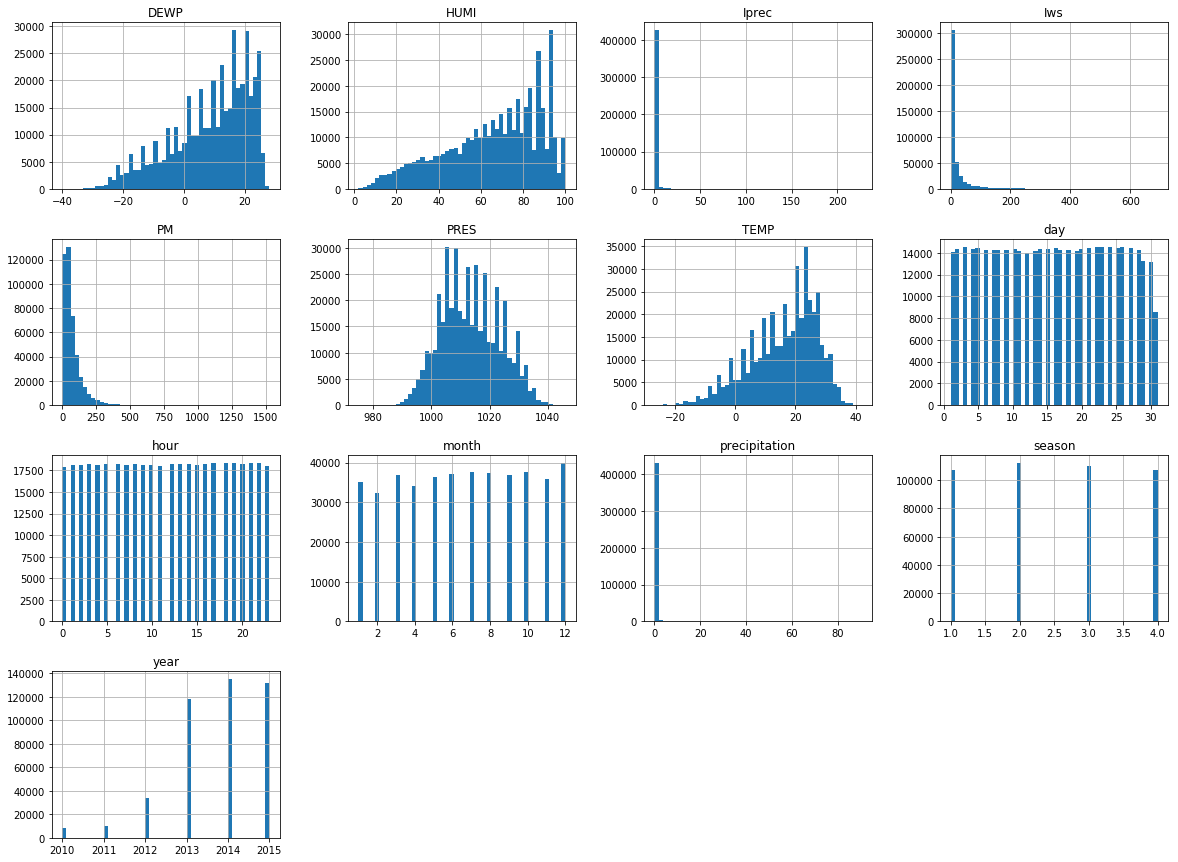

In [9]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
DATA_BEFORE_SPLIT = data.copy()

# Before we start doing analysis create TEST SET and put aside

I will go for 20 % of the data for test set

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
print('Train instances:', len(train_set), '\nTest instances: ', len(test_set))

Train instances: 349433 
Test instances:  87359


OK, now we are safe that we have a test set that hasn't been seen by us

### Let's Analyze our train data

Let's see a correlations to our PM values

In [13]:
data = train_set.copy()

In [14]:
corr_matrix = data.corr()

In [15]:
corr_matrix['PM'].sort_values(ascending=False)

PM               1.000000
PRES             0.209511
season           0.185324
HUMI             0.113361
day              0.050609
hour            -0.017481
precipitation   -0.052139
month           -0.067311
Iprec           -0.073353
year            -0.093944
Iws             -0.157519
DEWP            -0.173405
TEMP            -0.291462
Name: PM, dtype: float64

As you can see TEMP, Iws, HUMI, season, PRES make impact the most. 

But correlation measures only linear relationship, but what if we have non-linear?

Let's have a plots of PM with each of these 'TEMP', 'Iws', 'HUMI', 'season', 'PRES'

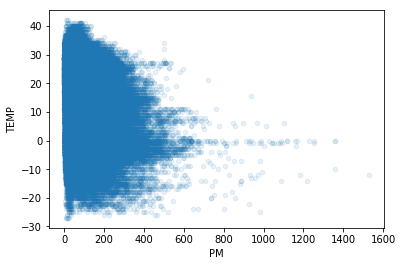

In [16]:
data.plot(kind='scatter', x='PM', y='TEMP', alpha=0.1)

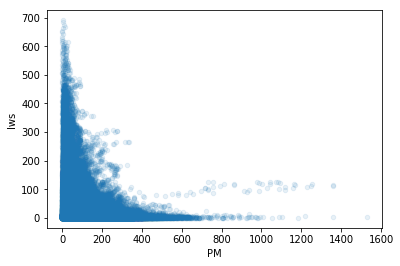

In [17]:
data.plot(kind='scatter', x='PM', y='Iws', alpha=0.1)

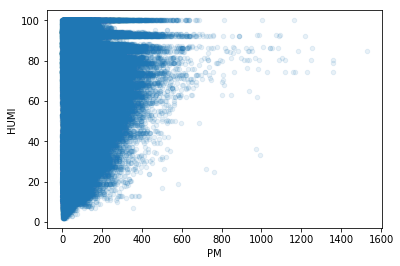

In [18]:
data.plot(kind='scatter', x='PM', y='HUMI', alpha=0.1)

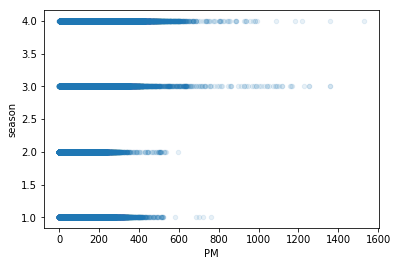

In [19]:
data.plot(kind='scatter', x='PM', y='season', alpha=0.1)

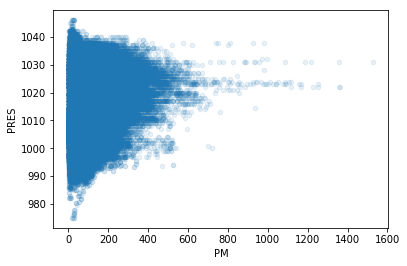

In [20]:
data.plot(kind='scatter', x='PM', y='PRES', alpha=0.1)

Well...not so many information we can get from it. There is a correlation, however not strong one

# Prepare data for algorithm

Before I feed my data to algorithm I need to prepare it first.

1. I need to deal with cbwd feature and transfer it to numerical format
2. I need to Standartize my data (Subtract mean and divide by variance)

In [21]:
data_labels = data['PM'].copy()

Extracting labels away from all features

In [22]:
data_labels.head()

224262     24.0
156106    117.0
281415     64.0
193788     45.0
384318    126.0
Name: PM, dtype: float64

In [23]:
data = data.drop("PM", axis=1)

Dropping PM attribute

In [24]:
data.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,City
224262,2013,8,1,10,2.0,24.4,72.00,997.700000,30.0,NE,13.4,0.0,0.0,Guangzhou
156106,2014,6,1,11,2.0,20.0,55.15,1006.000000,30.0,cv,4.0,0.0,0.0,Chengdu
281415,2015,12,20,12,4.0,7.5,47.00,1015.200012,19.1,NE,5.6,0.0,0.0,Guangzhou
193788,2015,11,22,7,3.0,14.0,87.93,1018.000000,16.0,cv,1.0,0.0,0.0,Chengdu
384318,2013,12,1,8,4.0,-9.0,79.26,1022.000000,-6.0,SE,11.0,0.0,0.0,Shenyang


In [25]:
def extract_labels(data):
    data_labels = data['PM'].copy()
    data = data.drop("PM", axis=1)
    return data, data_labels

**Handling text attributes cbwd and City**. 

We will convert labels to numbers. 
We will use OneHot encoding to convert categorical data (City) to numberical and convert cbwd to Simple Numbers

In [26]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [27]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

In [28]:
num_attribs = list(data.columns)
num_attribs.remove('cbwd')
num_attribs.remove('City')


transform_pipeline = ColumnTransformer([
        ("cbwd", OrdinalEncoder(), ['cbwd']),
        ("city", OneHotEncoder(), ['City']),
        ("num", num_pipeline, num_attribs),
    ])

data_prepared = transform_pipeline.fit_transform(data)

In [29]:
data_prepared

array([[ 0.        ,  0.        ,  0.        , ..., -0.1676407 ,
        -0.10361672, -0.1186751 ],
       [ 4.        ,  0.        ,  1.        , ..., -0.37912035,
        -0.10361672, -0.1186751 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.34312381,
        -0.10361672, -0.1186751 ],
       ...,
       [ 1.        ,  0.        ,  1.        , ..., -0.44661385,
        -0.10361672, -0.1186751 ],
       [ 1.        ,  0.        ,  1.        , ..., -0.44661385,
        -0.10361672, -0.1186751 ],
       [ 1.        ,  0.        ,  1.        , ..., -0.44661385,
        -0.10361672, -0.1186751 ]])

In [30]:
data_prepared.shape

(349433, 18)

In [31]:
data_labels.shape

(349433,)

Now we have data centered at 0 which is nice for our ML algorithm

# Prepare Test Set

Prepare Data for Testing. We have to prepare data in the same way as train data

In [32]:
data_test = test_set.drop('PM', axis=1)
data_test_labels = test_set['PM'].copy()

In [33]:
data_test.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,City
21160,2012,8,6,11,2.0,23.0,59.00,1010.0,32.0,cv,0.89,0.0,0.0,Beijing
418796,2015,4,8,10,1.0,-9.0,28.88,1026.0,8.0,SW,13.00,0.0,0.0,Shenyang
221464,2013,6,8,19,2.0,25.8,83.00,993.4,29.0,SE,2.40,0.0,0.0,Guangzhou
399474,2014,7,8,10,2.0,20.0,88.45,1002.0,22.0,SE,2.00,0.0,0.0,Shenyang
141204,2013,10,27,17,3.0,12.0,60.03,1016.0,20.0,cv,6.00,0.0,0.0,Chengdu


In [34]:
data_test_labels.head()

21160      61.0
418796     66.0
221464     24.0
399474     43.0
141204    133.0
Name: PM, dtype: float64

In [35]:
data_test_prepared = transform_pipeline.transform(data_test)

Test set is prepared as well

# Summary of all steps above

In [36]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

DATASET_DIR_PATH = 'PREP_DATASET'
DATASET_FILE_NAME = 'PREP_PM_DATASET.csv'

def get_data(DATASET_DIR_PATH=DATASET_DIR_PATH, DATASET_FILE_NAME=DATASET_FILE_NAME):
    DATASET_FILE_PATH = os.path.join(DATASET_DIR_PATH, DATASET_FILE_NAME)
    data = pd.read_csv(DATASET_FILE_PATH)
    data = data.drop(['Unnamed: 0'], axis=1)
    return data

def extract_data_and_labels(data):
    data_labels = data['PM'].copy()
    data = data.drop("PM", axis=1)
    return data, data_labels

def prep_data_for_algo(data):
    num_attribs = list(data.columns)
    num_attribs.remove('cbwd')
    num_attribs.remove('City')
    
    num_pipeline = Pipeline([
            ('std_scaler', StandardScaler()),
        ])
    
    transform_pipeline = ColumnTransformer([
            ("cbwd", OrdinalEncoder(), ['cbwd']),
            ("city", OneHotEncoder(), ['City']),
            ("num", num_pipeline, num_attribs),
        ])
    data_prepared = transform_pipeline.fit_transform(data)
    return data_prepared

data = get_data()
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

data_train, data_train_labels = extract_data_and_labels(train_set)
data_test, data_test_labels = extract_data_and_labels(test_set)

data_train_prepared = prep_data_for_algo(data_train)
data_test_prepared = prep_data_for_algo(data_test)

# Training

Finally we are ready to start training. I will train different ML algorithms model and try to predict on the same data it was trained in order to check whether ML algorithm learned something  

## Train and Cross Validate

So, I have decided to combine training and Cross Validation steps in one section in order to find best model for TEST evaluation

as a Scoring technique in Cross Validation I will use MSE

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score

In [38]:
def display_results(scores):
    print('-----------------------------------------\n')
    print('Cross Validation MSE\n')
    print('Scores: ', scores)
    print('Average MSE: ', scores.mean())
    print('Average RMSE: ', np.sqrt(scores.mean()))
    print('\n-----------------------------------------\n')

### Linear Regression 

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
lin_reg = LinearRegression()

In [41]:
lin_reg_scores = cross_val_score(lin_reg, data_train_prepared, data_train_labels, 
                             scoring="neg_mean_squared_error", cv=5)
display_results(-lin_reg_scores)

-----------------------------------------

Cross Validation MSE

Scores:  [3670.07389236 3670.40134251 3716.05186812 3604.54286775 3680.36387152]
Average MSE:  3668.2867684518183
Average RMSE:  60.56638315478165

-----------------------------------------



In [42]:
lin_reg.fit(data_train_prepared, data_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Decision Tree regressor

Imperically, I tried to find nice parameters and tune the model according to the Cross Validation scores

In [43]:
from sklearn.tree import DecisionTreeRegressor

In [44]:
tree_reg = DecisionTreeRegressor(max_features=18, max_depth=25)

In [45]:
tree_reg_scores = cross_val_score(tree_reg, data_train_prepared, data_train_labels, 
                             scoring="neg_mean_squared_error", cv=5)
display_results(-tree_reg_scores)

-----------------------------------------

Cross Validation MSE

Scores:  [755.19767942 794.21329753 764.11336236 769.79543265 799.38358902]
Average MSE:  776.5406721950364
Average RMSE:  27.866479364911463

-----------------------------------------



In [46]:
tree_reg.fit(data_train_prepared, data_train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=18,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### Random Forest Regressor

Imperically, I tried to find nice parameters and tune the model according to the Cross Validation scores

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
random_forest_reg = RandomForestRegressor(n_estimators=100, max_features=18, max_depth=25)

In [49]:
random_forest_reg_scores = cross_val_score(random_forest_reg, data_train_prepared, data_train_labels, 
                             scoring="neg_mean_squared_error", cv=5)
display_results(-random_forest_reg_scores)

-----------------------------------------

Cross Validation MSE

Scores:  [503.01596906 527.66653717 531.14993499 514.08822318 522.14708487]
Average MSE:  519.6135498551554
Average RMSE:  22.7950334471164

-----------------------------------------



In [50]:
random_forest_reg.fit(data_train_prepared, data_train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=18, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# TEST SET EVALUATION 

We are going to use trained models for testing one by one

Below, evaluation metrics will be used for evaluation

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [52]:
def predict_and_evaluate(model, data_test, data_test_labels, display=True):
    model_predictions = model.predict(data_test)
    model_mse = mean_squared_error(data_test_labels, model_predictions)
    model_rmse = np.sqrt(model_mse)
    model_r2 = r2_score(data_test_labels, model_predictions)
    if display:
        print('-> TEST SET EVALUATION', '\nMSE: ', model_mse, '\nRMSE: ', 
          model_rmse, '\nR2 score: ', model_r2)
    results = [model_mse, model_rmse, model_r2]
    return model_predictions, results

In [53]:
def plot_actual_vs_predicted(actual, predicted):
    fig,ax = plt.subplots()
    ax.scatter(actual, predicted)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    fig.show()

Let's start with Linear Regression

## Linear Regression

In [54]:
lin_reg_predictions, lin_reg_results = predict_and_evaluate(lin_reg, data_test_prepared, data_test_labels)

-> TEST SET EVALUATION 
MSE:  3592.9538167304863 
RMSE:  59.94125304604906 
R2 score:  0.2199383632162102


C:\Users\Aziz\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


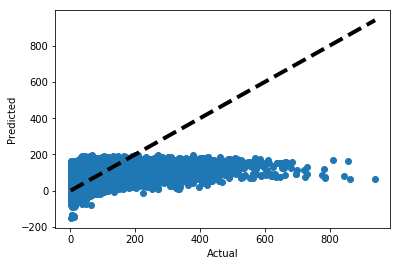

In [55]:
plot_actual_vs_predicted(data_test_labels, lin_reg_predictions)

## Decision Tree

In [56]:
tree_predictions, tree_results = predict_and_evaluate(tree_reg, data_test_prepared, data_test_labels)

-> TEST SET EVALUATION 
MSE:  715.3845078856812 
RMSE:  26.746672837676112 
R2 score:  0.8446837786913501


C:\Users\Aziz\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


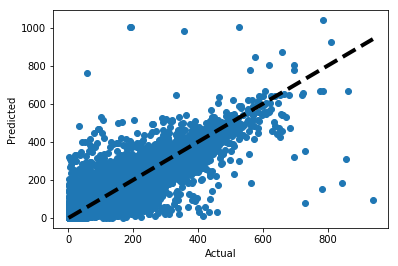

In [57]:
plot_actual_vs_predicted(data_test_labels, tree_predictions)

## Random Forest

In [58]:
rnd_clf_predictions, rnd_clf_results = predict_and_evaluate(random_forest_reg, data_test_prepared, data_test_labels)

-> TEST SET EVALUATION 
MSE:  476.66116139267785 
RMSE:  21.832571112736076 
R2 score:  0.896512701049526


C:\Users\Aziz\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


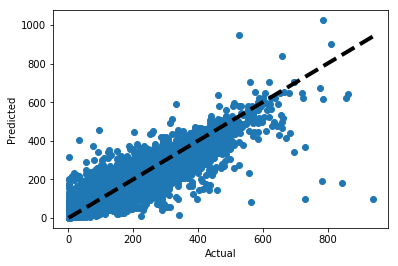

In [59]:
plot_actual_vs_predicted(data_test_labels, rnd_clf_predictions)

In [60]:
test_results = [lin_reg_results, tree_results, rnd_clf_results]

# RESULTS SUMMARY

In [61]:
def plot_final_result(title, results, metrics_index):
    plt.style.use('ggplot')
    x = ['Linear Regression', 'Decision Tree', 'Random Forest']
    vals = []
    for model in results:
        vals.append(model[metrics_index])

    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, vals, color=['red', 'green', 'blue'])
    plt.xlabel("Models")
    plt.ylabel("Value")
    plt.title(title)
    plt.xticks(x_pos, x)
    plt.show()

## Mean Square Error

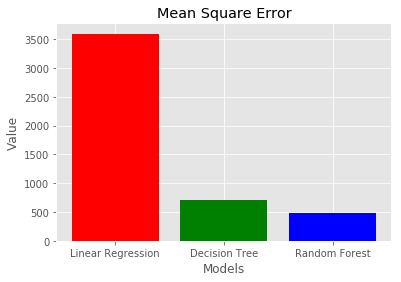

In [62]:
plot_final_result(title='Mean Square Error', results=test_results, metrics_index=0)

The mean squared error tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them

**Conclusion**: **BEST MODEL - RANDOM FOREST** average error in square is MSE:  474.6362469150816

## Root Mean Square Error

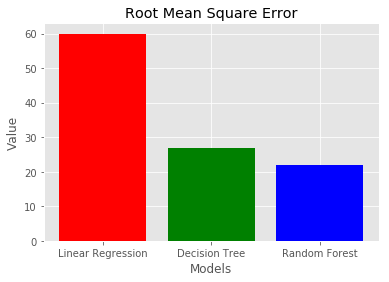

In [63]:
plot_final_result(title='Root Mean Square Error', results=test_results, metrics_index=1)

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

**Conclusion**: **BEST MODEL - RANDOM FOREST** predicting us PM2.5 valu with error +-20 units. RMSE:  21.786148051344036

## R2 score

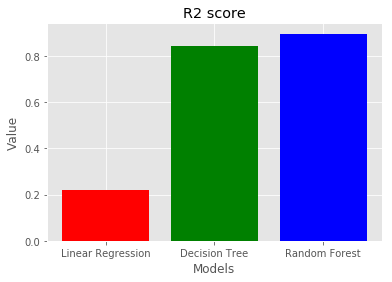

In [64]:
plot_final_result(title='R2 score', results=test_results, metrics_index=2)

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

* 0% indicates that the model explains none of the variability of the response data around its mean.
* 100% indicates that the model explains all the variability of the response data around its mean.

**Conclusion**: **BEST MODEL - RANDOM FOREST** explains 90% the variability of the response data around its mean. R2 score:  0.8969523276582472